In [131]:
# Dataset https://snap.stanford.edu/data/reddit_threads.html
import torch
from torch import nn as nn
import torch.nn.functional as F
from torch.nn import Linear
import numpy as np
import pandas as pd
import json 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import DataLoader, Data
import warnings
import matplotlib.pyplot as plt
import networkx as nx
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

print(torch.__version__)
print(torch.version.cuda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2.0.1+cu117
11.7
cuda


In [169]:
filename_graphs = 'datasets/reddit_threads/reddit_edges.json'
filename_targets = 'datasets/reddit_threads/reddit_target.csv'

labels = pd.read_csv(filename_targets)
# Load the data
with open(filename_graphs, 'r') as f:
    graphs = json.load(f)

num_sample = 100000
labels = labels[:num_sample]
print(labels.shape)
graphs = {k: graphs[str(k)] for k in labels['id'][:num_sample]}



(100000, 2)


In [170]:
data_list = []
y = labels['target'].values
num_features = 5

for idx, edge_list in graphs.items():
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous().view(2, -1)
    label = torch.tensor(y[int(idx)])
    num_nodes = edge_index.max().item() + 1
    x = torch.zeros(num_nodes, num_features)
    G = nx.from_edgelist(edge_list)

    # Compute the centrality measures as node features
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, tol=1e-3, max_iter=150)
    clustering_coefficient = nx.clustering(G)
    
    for i in range(num_nodes):
        if i not in degree_centrality:
            degree_centrality[i] = 0
        else:
            degree_centrality[i] = degree_centrality[i]
        if i not in betweenness_centrality:
            betweenness_centrality[i] = 0
        else:
            betweenness_centrality[i] = betweenness_centrality[i]
        if i not in closeness_centrality:
            closeness_centrality[i] = 0
        else:
            closeness_centrality[i] = closeness_centrality[i]
        if i not in eigenvector_centrality:
            eigenvector_centrality[i] = 0
        else:
            eigenvector_centrality[i] = eigenvector_centrality[i]
        if i not in clustering_coefficient:
            clustering_coefficient[i] = 0
        else:
            clustering_coefficient[i] = clustering_coefficient[i]
        
        x[i][0] = degree_centrality[i]
        x[i][1] = betweenness_centrality[i]
        x[i][2] = closeness_centrality[i]
        x[i][3] = eigenvector_centrality[i]
        x[i][4] = clustering_coefficient[i]

    G = nx.from_edgelist(edge_list)
    data_list.append(Data(edge_index=edge_index, y=label, x=x))


In [171]:
# XGBoost baseline
X_xgb = []
y_xgb = []

for data in data_list:
    g = sum(data.x)
    h = torch.tensor([max(data.x[:, 0]), max(data.x[:, 1]), max(data.x[:, 2]), max(data.x[:, 3]), max(data.x[:, 4])])
    graph = torch.cat((g, h))
    X_xgb.append(graph.detach().numpy())
    y_xgb.append(data.y.detach().numpy())

label_encoder = LabelEncoder()
y_xgb = label_encoder.fit_transform(y_xgb)
X_xgb, y_xgb = np.array(X_xgb), np.array(y_xgb)
print(label_encoder.inverse_transform([0, 1]))
print(X_xgb.shape, y_xgb.shape)

X_train, X_test, y_train, y_test = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

xgb_model = xgb.XGBClassifier(max_depth=4, learning_rate=0.2, n_estimators=500, n_jobs=-1, subsample=0.9)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))




[0 1]
(100000, 10) (100000,)
(80000, 10) (20000, 10) (80000,) (20000,)
              precision    recall  f1-score   support

           0       0.81      0.70      0.75      9662
           1       0.75      0.84      0.79     10338

    accuracy                           0.77     20000
   macro avg       0.78      0.77      0.77     20000
weighted avg       0.78      0.77      0.77     20000



In [105]:
print(data_list[12].edge_index)
print(data_list[12].y)
print(data_list[12].x)



tensor([[ 0,  1,  1,  2,  2,  3,  4,  5,  6,  6,  7,  8,  8,  8,  8,  8,  8,  8,
          8,  8, 10, 11],
        [ 8,  8, 11,  8, 10,  8,  8,  8,  8, 17,  8,  8,  9, 11, 12, 13, 14, 15,
         16, 17, 12, 17]])
tensor(1)
tensor([[0.0588, 0.0000, 0.5000, 0.1500, 0.0000],
        [0.1176, 0.0000, 0.5152, 0.2007, 1.0000],
        [0.1176, 0.0551, 0.5312, 0.1645, 0.0000],
        [0.0588, 0.0000, 0.5000, 0.1500, 0.0000],
        [0.0588, 0.0000, 0.5000, 0.1500, 0.0000],
        [0.0588, 0.0000, 0.5000, 0.1500, 0.0000],
        [0.1176, 0.0000, 0.5152, 0.2007, 1.0000],
        [0.0588, 0.0000, 0.5000, 0.1500, 0.0000],
        [1.0588, 0.9522, 0.9444, 0.7196, 0.0250],
        [0.0588, 0.0000, 0.5000, 0.1500, 0.0000],
        [0.1176, 0.0037, 0.3696, 0.0693, 0.0000],
        [0.1765, 0.0037, 0.5312, 0.2427, 0.6667],
        [0.1176, 0.0551, 0.5312, 0.1645, 0.0000],
        [0.0588, 0.0000, 0.5000, 0.1500, 0.0000],
        [0.0588, 0.0000, 0.5000, 0.1500, 0.0000],
        [0.0588, 0.0000, 

In [106]:
embedding_size = 16

class GNN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)

        self.initial_conv = GCNConv(num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)

        self.fc1 = nn.Linear(embedding_size*2, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 64)
        self.out = nn.Linear(64, 2)
    
    def forward(self, x, edge_index, batch_index):
        x = self.initial_conv(x, edge_index)
        x = F.relu(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        out = self.out(x)

        return out, x

In [101]:
def evaluate(model, val_loader):
    model.eval()
    predictions = []
    labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output, embedding = model(data.x, data.edge_index, data.batch)
            for i in range(len(output)):
                prediction = torch.argmax(output[i])
                if prediction == data.y[i]:
                    correct += 1
                total += 1
    return correct/total
                


GNN(
  (initial_conv): GCNConv(5, 16)
  (conv1): GCNConv(16, 16)
  (conv2): GCNConv(16, 16)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=2, bias=True)
)
Epoch:  0 , Cross entropy loss:  0.4331711232662201
Accuracy at epoch 0 on validation set: 0.760625
Accuracy at epoch 1 on validation set: 0.76465
Accuracy at epoch 2 on validation set: 0.766225
Accuracy at epoch 3 on validation set: 0.765975
Accuracy at epoch 4 on validation set: 0.76845
Accuracy at epoch 5 on validation set: 0.769625
Accuracy at epoch 6 on validation set: 0.7692
Accuracy at epoch 7 on validation set: 0.7695
Accuracy at epoch 8 on validation set: 0.7698
Accuracy at epoch 9 on validation set: 0.770575
Accuracy at epoch 10 on validation set: 0.770825
Accuracy at epoch 11 on validation set: 0.77
Accuracy at epoch 12 on validation set: 0.7707
Ac

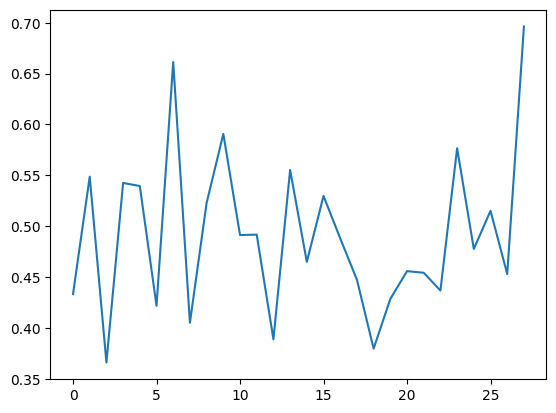

In [113]:
warnings.filterwarnings('ignore')
model = GNN().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

data_size = len(data_list)
batch_size = 64

train_loader = DataLoader(data_list[:int(data_size*0.6)], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_list[int(data_size*0.6):int(data_size*0.8)], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_list[int(data_size*0.8):], batch_size=batch_size, shuffle=True)
epochs = 1000
loss_over_time = []
delay = 0
delay_threshold = 5
max_accuracy = 0

for epoch in range(epochs+1):
    for batch in train_loader:
        batch.to(device)
        model.zero_grad()
        pred, embedding = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(pred, batch.y)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print('Epoch: ', epoch, ', Cross entropy loss: ', loss.item())
    # Early stopping
    current_accuracy = evaluate(model, val_loader)
    if current_accuracy < max_accuracy:
        delay += 1
        if delay >= delay_threshold:
            print(f'Early stopping at epoch {epoch}')
            break
    else:
        delay = 0
        max_accuracy = current_accuracy
    print(f'Accuracy at epoch {epoch} on validation set: {current_accuracy}')
    loss_over_time.append(loss.item())

plt.plot(loss_over_time)
    

In [114]:
print(evaluate(model, test_loader))

0.772725
